# Import and misc

In [1]:
!pip install torchaudio==0.9.1

     |████████████████████████████████| 1.9 MB 5.4 MB/s 
     |████████████████████████████████| 831.4 MB 6.8 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 0.10.0+cu111
    Uninstalling torchaudio-0.10.0+cu111:
      Successfully uninstalled torchaudio-0.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have torch 1.9.1 which is incompatible.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.9.1 which is incompatible.


In [2]:
from typing import Tuple, Union, List, Callable, Optional
from tqdm import tqdm
from itertools import islice
import pathlib
import dataclasses

import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
from torch import nn
from torch import distributions
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torch.nn.utils.rnn import pad_sequence

import torchaudio
from IPython import display as display_

# Task

In this notebook we will implement a model for finding a keyword in a stream.

We will implement the version with CRNN because it is easy and improves the model. 
(from https://www.dropbox.com/s/22ah2ba7dug6pzw/KWS_Attention.pdf)

In [3]:
@dataclasses.dataclass
class TaskConfig:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 3e-4
    weight_decay: float = 1e-5
    num_epochs: int = 20
    n_mels: int = 40
    cnn_out_channels: int = 8
    kernel_size: Tuple[int, int] = (5, 20)
    stride: Tuple[int, int] = (2, 8)
    hidden_size: int = 64
    gru_num_layers: int = 2
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu')

# Data

In [4]:
!wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz -O speech_commands_v0.01.tar.gz
!mkdir speech_commands && tar -C speech_commands -xvzf speech_commands_v0.01.tar.gz 1> log

--2021-11-22 15:59:23--  http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 108.177.120.128, 2607:f8b0:4001:c18::80
Connecting to download.tensorflow.org (download.tensorflow.org)|108.177.120.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1489096277 (1.4G) [application/gzip]
Saving to: ‘speech_commands_v0.01.tar.gz’

speech_commands_v0. 100%[===================>]   1.39G  31.6MB/s    in 15s     

2021-11-22 15:59:38 (97.4 MB/s) - ‘speech_commands_v0.01.tar.gz’ saved [1489096277/1489096277]



In [5]:
class SpeechCommandDataset(Dataset):

    def __init__(
        self,
        transform: Optional[Callable] = None,
        path2dir: str = None,
        keywords: Union[str, List[str]] = None,
        csv: Optional[pd.DataFrame] = None
    ):        
        self.transform = transform

        if csv is None:
            path2dir = pathlib.Path(path2dir)
            keywords = keywords if isinstance(keywords, list) else [keywords]
            
            all_keywords = [
                p.stem for p in path2dir.glob('*')
                if p.is_dir() and not p.stem.startswith('_')
            ]

            triplets = []
            for keyword in all_keywords:
                paths = (path2dir / keyword).rglob('*.wav')
                if keyword in keywords:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 1))
                else:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 0))
            
            self.csv = pd.DataFrame(
                triplets,
                columns=['path', 'keyword', 'label']
            )

        else:
            self.csv = csv
    
    def __getitem__(self, index: int):
        instance = self.csv.iloc[index]

        path2wav = instance['path']
        wav, sr = torchaudio.load(path2wav)
        wav = wav.sum(dim=0)
        
        if self.transform:
            wav = self.transform(wav)

        return {
            'wav': wav,
            'keywors': instance['keyword'],
            'label': instance['label']
        }

    def __len__(self):
        return len(self.csv)

In [6]:
dataset = SpeechCommandDataset(
    path2dir='speech_commands', keywords=TaskConfig.keyword
)

In [7]:
dataset.csv.sample(5)

,path,keyword,label
26164,speech_commands/up/30f31e42_nohash_2.wav,up,0
17968,speech_commands/marvin/ea7ca285_nohash_1.wav,marvin,0
62027,speech_commands/cat/6b81fead_nohash_1.wav,cat,0
1972,speech_commands/no/e41e41f7_nohash_0.wav,no,0
41971,speech_commands/eight/6794a793_nohash_2.wav,eight,0


### Augmentations

In [8]:
class AugsCreation:

    def __init__(self):
        self.background_noises = [
            'speech_commands/_background_noise_/white_noise.wav',
            'speech_commands/_background_noise_/dude_miaowing.wav',
            'speech_commands/_background_noise_/doing_the_dishes.wav',
            'speech_commands/_background_noise_/exercise_bike.wav',
            'speech_commands/_background_noise_/pink_noise.wav',
            'speech_commands/_background_noise_/running_tap.wav'
        ]

        self.noises = [
            torchaudio.load(p)[0].squeeze()
            for p in self.background_noises
        ]

    def add_rand_noise(self, audio):

        # randomly choose noise
        noise_num = torch.randint(low=0, high=len(
            self.background_noises), size=(1,)).item()
        noise = self.noises[noise_num]

        noise_level = torch.Tensor([1])  # [0, 40]

        noise_energy = torch.norm(noise)
        audio_energy = torch.norm(audio)
        alpha = (audio_energy / noise_energy) * \
            torch.pow(10, -noise_level / 20)

        start = torch.randint(
            low=0,
            high=max(int(noise.size(0) - audio.size(0) - 1), 1),
            size=(1,)
        ).item()
        noise_sample = noise[start: start + audio.size(0)]

        audio_new = audio + alpha * noise_sample
        audio_new.clamp_(-1, 1)
        return audio_new

    def __call__(self, wav):
        aug_num = torch.randint(low=0, high=4, size=(1,)).item()   # choose 1 random aug from augs
        augs = [
            lambda x: x,
            lambda x: (x + distributions.Normal(0, 0.01).sample(x.size())).clamp_(-1, 1),
            lambda x: torchaudio.transforms.Vol(.25)(x),
            lambda x: self.add_rand_noise(x)
        ]

        return augs[aug_num](wav)

In [9]:
indexes = torch.randperm(len(dataset))
train_indexes = indexes[:int(len(dataset) * 0.8)]
val_indexes = indexes[int(len(dataset) * 0.8):]

train_df = dataset.csv.iloc[train_indexes].reset_index(drop=True)
val_df = dataset.csv.iloc[val_indexes].reset_index(drop=True)

In [10]:
# Sample is a dict of utt, word and label
train_set = SpeechCommandDataset(csv=train_df, transform=AugsCreation())
val_set = SpeechCommandDataset(csv=val_df)

### Sampler for oversampling:

In [11]:
# We should provide to WeightedRandomSampler _weight for every sample_; by default it is 1/len(target)

def get_sampler(target):
    class_sample_count = np.array(
        [len(np.where(target == t)[0]) for t in np.unique(target)])   # for every class count it's number of occ.
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in target])
    samples_weight = torch.from_numpy(samples_weight)
    samples_weigth = samples_weight.float()
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
    return sampler

In [12]:
train_sampler = get_sampler(train_set.csv['label'].values)

In [13]:
class Collator:
    
    def __call__(self, data):
        wavs = []
        labels = []    

        for el in data:
            wavs.append(el['wav'])
            labels.append(el['label'])

        # torch.nn.utils.rnn.pad_sequence takes list(Tensors) and returns padded (with 0.0) Tensor
        wavs = pad_sequence(wavs, batch_first=True)    
        labels = torch.Tensor(labels).long()
        return wavs, labels

###  Dataloaders

In [14]:
# Here we are obliged to use shuffle=False because of our sampler with randomness inside.

train_loader = DataLoader(train_set, batch_size=TaskConfig.batch_size,
                          shuffle=False, collate_fn=Collator(),
                          sampler=train_sampler,
                          num_workers=2, pin_memory=True)

val_loader = DataLoader(val_set, batch_size=TaskConfig.batch_size,
                        shuffle=False, collate_fn=Collator(),
                        num_workers=2, pin_memory=True)

### Creating MelSpecs on GPU for speeeed: 

In [15]:
class LogMelspec:

    def __init__(self, is_train, config):
        # with augmentations
        if is_train:
            self.melspec = nn.Sequential(
                torchaudio.transforms.MelSpectrogram(
                    sample_rate=config.sample_rate,
                    n_fft=400,
                    win_length=400,
                    hop_length=160,
                    n_mels=config.n_mels
                ),
                torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
                torchaudio.transforms.TimeMasking(time_mask_param=35),
            ).to(config.device)

        # no augmentations
        else:
            self.melspec = torchaudio.transforms.MelSpectrogram(
                sample_rate=config.sample_rate,
                n_fft=400,
                win_length=400,
                hop_length=160,
                n_mels=config.n_mels
            ).to(config.device)

    def __call__(self, batch):
        # already on device
        return torch.log(self.melspec(batch).clamp_(min=1e-9, max=1e9))

In [16]:
melspec_train = LogMelspec(is_train=True, config=TaskConfig)
melspec_val = LogMelspec(is_train=False, config=TaskConfig)

### Quality measurment functions:

In [17]:
# FA - true: 0, model: 1
# FR - true: 1, model: 0

def count_FA_FR(preds, labels):
    FA = torch.sum(preds[labels == 0])
    FR = torch.sum(labels[preds == 0])
    
    # torch.numel - returns total number of elements in tensor
    return FA.item() / torch.numel(preds), FR.item() / torch.numel(preds)

In [18]:
def get_au_fa_fr(probs, labels):
    sorted_probs, _ = torch.sort(probs)
    sorted_probs = torch.cat((torch.Tensor([0]), sorted_probs, torch.Tensor([1])))
    labels = torch.cat(labels, dim=0)
        
    FAs, FRs = [], []
    for prob in sorted_probs:
        preds = (probs >= prob) * 1
        FA, FR = count_FA_FR(preds, labels)        
        FAs.append(FA)
        FRs.append(FR)
    # plt.plot(FAs, FRs)
    # plt.show()

    # ~ area under curve using trapezoidal rule
    return -np.trapz(FRs, x=FAs)

# Model

In [19]:
class Attention(nn.Module):

    def __init__(self, hidden_size: int):
        super().__init__()

        self.energy = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, input):
        energy = self.energy(input)
        alpha = torch.softmax(energy, dim=-2)
        return (input * alpha).sum(dim=-2)

class CRNN(nn.Module):

    def __init__(self, config: TaskConfig):
        super().__init__()
        self.config = config

        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=config.cnn_out_channels,
                kernel_size=config.kernel_size, stride=config.stride
            ),
            nn.Flatten(start_dim=1, end_dim=2),
        )

        self.conv_out_frequency = (config.n_mels - config.kernel_size[0]) // \
            config.stride[0] + 1
        
        self.gru = nn.GRU(
            input_size=self.conv_out_frequency * config.cnn_out_channels,
            hidden_size=config.hidden_size,
            num_layers=config.gru_num_layers,
            dropout=0.1,
            bidirectional=config.bidirectional,
            batch_first=True
        )

        self.attention = Attention(config.hidden_size)
        self.classifier = nn.Linear(config.hidden_size, config.num_classes)
    
    def forward(self, input):
        input = input.unsqueeze(dim=1)
        conv_output = self.conv(input).transpose(-1, -2)
        gru_output, _ = self.gru(conv_output)
        contex_vector = self.attention(gru_output)
        output = self.classifier(contex_vector)
        return output

config = TaskConfig()
model = CRNN(config)
model

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)

In [20]:
def train_epoch(model, opt, loader, log_melspec, device):
    model.train()
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()

        # run model # with autocast():
        logits = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(logits, dim=-1)
        loss = F.cross_entropy(logits, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        opt.step()

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    return acc

In [21]:
@torch.no_grad()
def validation(model, loader, log_melspec, device):
    model.eval()

    val_losses, accs, FAs, FRs = [], [], [], []
    all_probs, all_labels = [], []
    for i, (batch, labels) in tqdm(enumerate(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        output = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(output, dim=-1)
        loss = F.cross_entropy(output, labels)

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        all_probs.append(probs[:, 1].cpu())
        all_labels.append(labels.cpu())
        val_losses.append(loss.item())
        accs.append(
            torch.sum(argmax_probs == labels).item() /  # ???
            torch.numel(argmax_probs)
        )
        FA, FR = count_FA_FR(argmax_probs, labels)
        FAs.append(FA)
        FRs.append(FR)

    # area under FA/FR curve for whole loader
    au_fa_fr = get_au_fa_fr(torch.cat(all_probs, dim=0).cpu(), all_labels)
    return au_fa_fr

In [22]:
from collections import defaultdict
from IPython.display import clear_output
from matplotlib import pyplot as plt

history = defaultdict(list)

# Training

In [23]:
config = TaskConfig()
model = CRNN(config).to(config.device)

print(model)

opt = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)


In [24]:
sum([p.numel() for p in model.parameters()])

70443

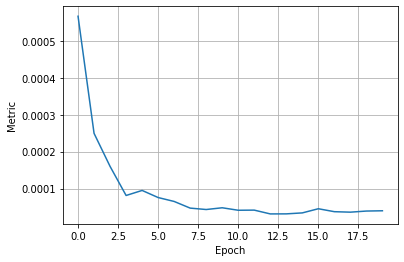

END OF EPOCH 19


In [ ]:
# TRAIN

for n in range(TaskConfig.num_epochs):

    train_epoch(model, opt, train_loader,
                melspec_train, config.device)

    au_fa_fr = validation(model, val_loader,
                          melspec_val, config.device)
    history['val_metric'].append(au_fa_fr)

    clear_output()
    plt.plot(history['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    print('END OF EPOCH', n)

In [ ]:
history

defaultdict(list,
            {'val_metric': [0.0005665350971613719,
              0.0002494375213433069,
              0.00015994817781680556,
              8.127203050729674e-05,
              9.491981182532213e-05,
              7.56804384237857e-05,
              6.509400901487576e-05,
              4.707201531988815e-05,
              4.3258752415551364e-05,
              4.798505009979978e-05,
              4.126559152345671e-05,
              4.162364437832401e-05,
              3.1353494991213534e-05,
              3.149074858557933e-05,
              3.409856687852952e-05,
              4.5359329164106214e-05,
              3.7392653143308715e-05,
              3.6097695318205306e-05,
              3.910533929909065e-05,
              3.986918538947423e-05]})

In [ ]:
torch.save(model, "base_model.pth")

### Reproduce

In [ ]:
history = defaultdict(list)
config = TaskConfig()
model = CRNN(config).to(config.device)

print(model)

opt = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)


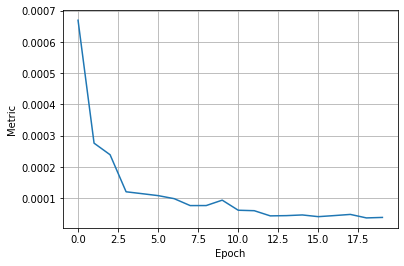

END OF EPOCH 19


In [ ]:
# TRAIN

for n in range(TaskConfig.num_epochs):

    train_epoch(model, opt, train_loader,
                melspec_train, config.device)

    au_fa_fr = validation(model, val_loader,
                          melspec_val, config.device)
    history['val_metric'].append(au_fa_fr)

    clear_output()
    plt.plot(history['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    print('END OF EPOCH', n)

In [ ]:
history

defaultdict(list,
            {'val_metric': [0.000668929262332049,
              0.00027623777753012457,
              0.000239244950074751,
              0.00012088461135078273,
              0.00011483351810352531,
              0.00010863323616673985,
              9.895387399016041e-05,
              7.682024001177994e-05,
              7.689185058275341e-05,
              9.416790083010079e-05,
              6.19491114396246e-05,
              6.048109473466867e-05,
              4.3927117744637006e-05,
              4.470886647776394e-05,
              4.689895644003562e-05,
              4.1432682855728125e-05,
              4.487595781003536e-05,
              4.859373995307418e-05,
              3.7416523333633206e-05,
              3.898002079988709e-05]})

#Streaming

In [25]:
class StreamingCRNN(CRNN):
    def __init__(self, config, max_window_length, streaming_step_size=1):
        super().__init__(config)

        self.max_window_length = max_window_length
        self.streaming_step_size = streaming_step_size
        self.receptive_field =  config.kernel_size[1]

        self.reset()

    def reset(self):
        self.hidden = None

        self.buffer = None
        self.gru_buffer = []

    def forward(self, input):
        input = input.unsqueeze(0).unsqueeze(0)
        outputs = []

        if self.buffer == None:
            self.buffer = input
        else:
            self.buffer = torch.cat((self.buffer, input), dim=-1)
        
        if self.buffer.shape[-1] < self.receptive_field:
            return []
        
        for i in range(self.receptive_field, self.buffer.shape[-1], self.streaming_step_size):
            cur_input = self.buffer[: ,: ,: , i - self.receptive_field:i]

            conv_output = self.conv(cur_input).transpose(-1, -2)
            gru_output, self.hidden = self.gru(conv_output, self.hidden)
            self.gru_buffer += [gru_output]
            if len(self.gru_buffer) > self.max_window_length:
                self.gru_buffer = self.gru_buffer[1:]

            contex_vector = self.attention(torch.cat(self.gru_buffer, dim=1))
            output = self.classifier(contex_vector)
            output = F.softmax(output, dim=-1)[0][1]
            outputs.append(output.item())

        self.buffer = self.buffer[:, :, :, -self.receptive_field:]
        return outputs


In [26]:
base_model = torch.load("base_model.pth")
config = TaskConfig()
max_window_length = 30
streaming_step_size = 5

streaming_kws = StreamingCRNN(config=config,
                              max_window_length=max_window_length,
                              streaming_step_size=streaming_step_size).to(config.device)
streaming_kws.load_state_dict(base_model.state_dict())
streaming_kws.eval()

StreamingCRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)

In [40]:
exmp = val_df.sample(20)
exmp

,path,keyword,label
7230,speech_commands/go/7c1d8533_nohash_3.wav,go,0
6598,speech_commands/no/da584bc0_nohash_3.wav,no,0
5181,speech_commands/up/c099668c_nohash_1.wav,up,0
5759,speech_commands/left/dec73123_nohash_1.wav,left,0
9503,speech_commands/sheila/650daf8e_nohash_0.wav,sheila,1
5459,speech_commands/dog/19b05529_nohash_0.wav,dog,0
2530,speech_commands/house/71bf8f48_nohash_0.wav,house,0
1233,speech_commands/on/d7467392_nohash_2.wav,on,0
9951,speech_commands/eight/5d9bb361_nohash_0.wav,eight,0
8063,speech_commands/bird/2275edbb_nohash_0.wav,bird,0


In [41]:
samples = []
labels = []

for i in range(20):
    sample = val_set[exmp.index[i]]
    sample, label = Collator()([sample])
    labels += [label.item()]
    samples += [melspec_val(sample.to(config.device))]

batch = torch.cat(samples, dim=-1)

In [42]:
batch.shape

torch.Size([1, 40, 1972])

[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]


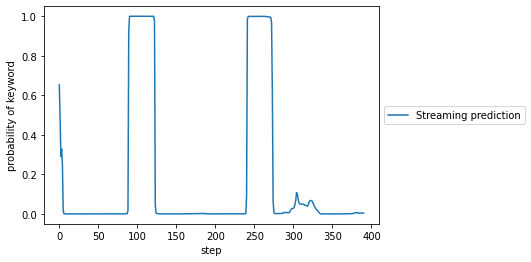

In [43]:
streaming_kws.reset()
outputs = []

for i in range(0, batch.size(-1), streaming_step_size):
    input = batch[:,:,i:i+streaming_step_size].squeeze(0)
    outputs += streaming_kws(input)

print(labels)
plt.plot(outputs, label='Streaming prediction', alpha=1)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("step")
plt.ylabel("probability of keyword")
plt.show()

#Distillation


In [31]:
import time


class Timer:

    def __init__(self, name: str, verbose=False):
        self.name = name
        self.verbose = verbose

    def __enter__(self):
        self.t = time.time()
        return self

    def __exit__(self, type, value, traceback):
        self.t = time.time() - self.t

        if self.verbose:
            print(f"{self.name.capitalize()} | Elapsed time : {self.t:.2f}")

In [32]:
!pip install thop

In [33]:
from thop import profile  # !pip install thop

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Conv1d(1, 1, 3, bias=False)
    
    def forward(self, x):
        return self.model(x)
        
profile(Model(), (torch.randn(1, 1, 4), ))  # -> (6.0 MACs, 3.0 parameters)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv1d'>.
[WARN] Cannot find rule for <class '__main__.Model'>. Treat it as zero Macs and zero Params.


(6.0, 3.0)

In [34]:
import tempfile

def get_size_in_megabytes(model):
    # https://pytorch.org/tutorials/recipes/recipes/dynamic_quantization.html#look-at-model-size
    with tempfile.TemporaryFile() as f:
        torch.save(model.state_dict(), f)
        size = f.tell() / 2**20
    return size

In [57]:
def get_model_information(model, batch, config, name="default"):
    print(f"{name} model information")

    model = model.to(config.device)
    batch = batch.to(config.device)

    macs, parameters = profile(model, (batch, ))
    print(f"\n\t{macs} MACs, {parameters} parameters")

    size = get_size_in_megabytes(model)
    print(f"\tModel size = {size} Mb")

    au_fa_fr = validation(model, val_loader, melspec_val, config.device)
    print(f"\tval_metric = {au_fa_fr}")
    if name != "default" and au_fa_fr < 5e-5 * 1.1:
        print("\tModel has enough quality")
        print("\t-Vincent, we happy?")
        print("\t-Yeah, we happy")
    elif name != "default":
        print("\tModel doesn't have enough quality")
        print("\tcry....")
    
    return {"name": name,
            "metric": au_fa_fr,
            "macs": macs,
            "parameters": parameters,
            "size": size,
            "ehough": au_fa_fr < 5e-5 * 1.1}

In [36]:
config = TaskConfig()

check_batch = None
for batch, labels in val_loader:
    batch = batch.to(config.device)
    check_batch = melspec_val(batch)
    break
print(check_batch.shape)

torch.Size([128, 40, 101])


In [37]:
_ = get_model_information(base_model, check_batch, config)

default model information
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CRNN'>. Treat it as zero Macs and zero Params.

	119527424.0 MACs, 70443.0 parameters
	Model size = 0.27530479431152344 Mb


102it [00:08, 12.32it/s]


	val_metric = 9.309374226549887e-06


In [55]:
@dataclasses.dataclass
class DistillTaskConfig:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 3e-4
    weight_decay: float = 1e-5
    num_epochs: int = 50
    n_mels: int = 40
    cnn_out_channels: int = 8
    kernel_size: Tuple[int, int] = (5, 20)
    stride: Tuple[int, int] = (2, 8)
    hidden_size: int = 64
    gru_num_layers: int = 2
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    alpha: float = 0.8
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu')

In [53]:
def train_one_epoch_with_teacher(model, teacher_model, opt, train_loader, melspec_train, config):
    model.train()

    for i, (batch, labels) in tqdm(enumerate(train_loader)):
        batch, labels = batch.to(config.device), labels.to(config.device)
        batch = melspec_train(batch)

        opt.zero_grad()

        logits = model(batch)
        probs = F.softmax(logits, dim=-1)
        loss_model = F.cross_entropy(logits, labels)

        with torch.no_grad():
            logits_teacher = teacher_model(batch)
            loss_teacher = F.cross_entropy(logits_teacher, labels)

        loss = loss_model * config.alpha + loss_teacher * (1 - config.alpha)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        opt.step()

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)


def train_with_teacher(model, teacher_model, opt, config, model_name='default'):
    history=defaultdict(list)

    for epoch in range(config.num_epochs):

        train_one_epoch_with_teacher(model, teacher_model, opt, train_loader, melspec_train, config)

        au_fa_fr = validation(model, val_loader, melspec_val, config.device)
        history['val_metric'].append(au_fa_fr)

        clear_output()
        plt.title(f"{model_name} training")
        plt.plot(history['val_metric'])
        plt.ylabel('Metric')
        plt.xlabel('Epoch')
        plt.grid()
        plt.savefig(f"{model_name}.png")
        plt.show()

        print('END OF EPOCH', epoch)
        if au_fa_fr < 5e-5:
            break
    return history

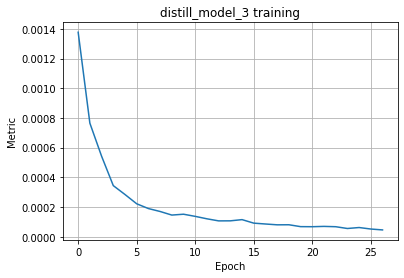

END OF EPOCH 26


In [56]:
distill_config = DistillTaskConfig()
count = -1
base_model = torch.load("base_model.pth").to(distill_config.device)
distill_models_history = []

for kernel in [20]:
    for cnn_channel in [3, 4]:
        for hidden in [16, 20]:
            for stride in [6]:
                count += 1

                distill_config.kernel_size = (5, kernel)
                distill_config.cnn_out_channels = cnn_channel
                distill_config.hidden_size = hidden
                distill_config.stride = (2, stride)

                model_name = f"distill_model_{count}"

                distill_model = CRNN(distill_config).to(distill_config.device)
                opt = torch.optim.Adam(
                    distill_model.parameters(),
                    lr=distill_config.learning_rate,
                    weight_decay=distill_config.weight_decay
                )

                history = train_with_teacher(distill_model, base_model, opt, distill_config, model_name=model_name)
                distill_models_history.append(history)

                torch.save(distill_model, f"{model_name}.pth")

#Quantization

In [69]:
from torch.quantization import quantize_dynamic

quan_model = quantize_dynamic(base_model.cpu())
torch.save(quan_model, "quan_base.pth")

In [66]:
config.device = torch.device("cpu")
melspec_val = LogMelspec(is_train=False, config=config)

In [70]:
_ = get_model_information(quan_model, check_batch, config, name="quan_base")

quan_base model information
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.rnn.PackedParameter'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.ModuleList'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.rnn.GRU'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.modules.linear.LinearPackedParams'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.linear.Linear'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.

102it [00:13,  7.46it/s]


	val_metric = 9.774842937877382e-06
	Model has enough quality
	-Vincent, we happy?
	-Yeah, we happy


In [72]:
info = []
for i in range(4):
    model = torch.load(f"distill_model_{i}.pth")
    d = get_model_information(model, check_batch, config, name=f"distill_{i}")
    print()
    info.append(d)

distill_0 model information
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CRNN'>. Treat it as zero Macs and zero Params.

	19784192.0 MACs, 5714.0 parameters
	Model size = 0.029557228088378906 Mb


102it [00:12,  7.99it/s]


	val_metric = 4.888018223696803e-05
	Model has enough quality
	-Vincent, we happy?
	-Yeah, we happy

distill_1 model information
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CRNN'>. Treat it as zero Macs and zero Params.

	23720448.0 MACs, 7866.0 parameters
	Model size = 0.037552833557128906 Mb


102it [00:13,  7.81it/s]


	val_metric = 4.768070517316257e-05
	Model has enough quality
	-Vincent, we happy?
	-Yeah, we happy

distill_2 model information
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CRNN'>. Treat it as zero Macs and zero Params.

	24590336.0 MACs, 6679.0 parameters
	Model size = 0.033219337463378906 Mb


102it [00:12,  7.89it/s]


	val_metric = 8.278778759290167e-05
	Model doesn't have enough quality
	cry....

distill_3 model information
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CRNN'>. Treat it as zero Macs and zero Params.

	28913664.0 MACs, 9047.0 parameters
	Model size = 0.042008399963378906 Mb


102it [00:12,  7.87it/s]


	val_metric = 4.610527261174643e-05
	Model has enough quality
	-Vincent, we happy?
	-Yeah, we happy



In [75]:
for i in [0, 1, 3]:
    model = torch.load(f"distill_model_{i}.pth")
    quan_model = quantize_dynamic(model.cpu())
    torch.save(quan_model, f"quan_model_{i}.pth")
    d = get_model_information(quan_model, check_batch, config, name=f"quan_{i}")
    info.append(d)

quan_0 model information
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.rnn.PackedParameter'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.ModuleList'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.rnn.GRU'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.modules.linear.LinearPackedParams'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.linear.Linear'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.

102it [00:13,  7.78it/s]


	val_metric = 4.726894439006517e-05
	Model has enough quality
	-Vincent, we happy?
	-Yeah, we happy
quan_1 model information
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.rnn.PackedParameter'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.ModuleList'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.rnn.GRU'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.modules.linear.LinearPackedParams'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.l

102it [00:13,  7.77it/s]


	val_metric = 4.938145623378225e-05
	Model has enough quality
	-Vincent, we happy?
	-Yeah, we happy
quan_3 model information
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.rnn.PackedParameter'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.ModuleList'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.rnn.GRU'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.modules.linear.LinearPackedParams'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.l

102it [00:13,  7.74it/s]


	val_metric = 4.520417292699705e-05
	Model has enough quality
	-Vincent, we happy?
	-Yeah, we happy


In [79]:
base_info = get_model_information(base_model, check_batch, config)

default model information
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CRNN'>. Treat it as zero Macs and zero Params.

	119527424.0 MACs, 70443.0 parameters
	Model size = 0.2764444351196289 Mb


102it [00:13,  7.73it/s]


	val_metric = 9.309374226549887e-06


In [83]:
for model_info in info:
    if model_info["ehough"]:
        print(model_info["name"])
        time_speed = base_info["macs"] / model_info["macs"]
        print(f"Time speed up - {time_speed}")
        compress = base_info["size"] / model_info["size"]
        print(f"Compression - {compress}")
        print()

distill_0
Time speed up - 6.0415620713749645
Compression - 9.352853870228762

distill_1
Time speed up - 5.0390036478231774
Compression - 7.361480051806892

distill_3
Time speed up - 4.133942484771214
Compression - 6.580694226883698

quan_0
Time speed up - 12.22966106134423
Compression - 11.886373887727068

quan_1
Time speed up - 12.22966106134423
Compression - 11.01885429733531

quan_3
Time speed up - 9.172245796008172
Compression - 10.410983011888087

